# NBA Winner Classifier

## Imports

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier

## Setup

In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


### Utils functions

In [41]:
def filter_from(items, cond):
    return list(filter(cond, items))

In [42]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [43]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [25]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [44]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [45]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="prec", hue="model", style="model",
        markers=True, dashes=False)
    a.set_title(
        f"{experiment_name}-prec")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [46]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [47]:
metrics = ['prec', 'bal_acc', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='prec', filter_val=None):
    second_metric = 'bal_acc' if metric == 'prec' else 'prec'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model.isin(filter_val))
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [48]:
season_games = sg.load_season_games_dataset()

## Dataset


In [179]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [49]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [50]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)

(9599, 405)
0
(9461, 405)


In [182]:
df[df.SEASON >= 2012]

SEASON_ID  TEAM_ID_HOME TEAM_ABBREVIATION_HOME  \
GAME_ID                                                     
0021200019     22012    1610612739                    CLE   
0021200021     22012    1610612740                    NOH   
0021200022     22012    1610612760                    OKC   
0021200024     22012    1610612756                    PHX   
0021200025     22012    1610612747                    LAL   
...              ...           ...                    ...   
0021701226     22017    1610612740                    NOP   
0021701227     22017    1610612760                    OKC   
0021701228     22017    1610612746                    LAC   
0021701229     22017    1610612757                    POR   
0021701230     22017    1610612758                    SAC   

                    TEAM_NAME_HOME  GAME_DATE MATCHUP_HOME WL_HOME  MIN_HOME  \
GAME_ID                                                                        
0021200019     Cleveland Cavaliers 2012-11-02  CLE vs. CHI       L       240   
0021200021     New Orleans Hornets 2012-11-02  NOH vs. UTA       W       240   
0021200022   Oklahoma City Thunder 2012-11-02  OKC vs. POR       W       240   
0021200024            Phoenix Suns 2012-11-02  PHX vs. DET       W       240   
0021200025      Los Angeles Lakers 2012-11-02  LAL vs. LAC       L       240   
...                            ...        ...          ...     ...       ...   
0021701226    New Orleans Pelicans 2018-04-11  NOP vs. SAS       W       240   
0021701227   Oklahoma City Thunder 2018-04-11  OKC vs. MEM       W       240   
0021701228             LA Clippers 2018-04-11  LAC vs. LAL       L       240   
0021701229  Portland Trail Blazers 2018-04-11  POR vs. UTA       W       240   
0021701230        Sacramento Kings 2018-04-11  SAC vs. HOU       W       240   

            FGM_HOME  FGA_HOME  ...  HOME_FT_MEAN  HOME_FT_MEAN_L10  \
GAME_ID                         ...                                   
0021200019        32        79  ...     -0.075758         -0.075758   
0021200021        37        81  ...      0.174948          0.174948   
0021200022        39        76  ...      0.004658          0.004658   
0021200024        40        92  ...      0.003497          0.003497   
0021200025        34        68  ...     -0.086481         -0.086481   
...              ...       ...  ...           ...               ...   
0021701226        52        88  ...      0.001313          0.061021   
0021701227        47        85  ...     -0.068136         -0.002186   
0021701228        41        83  ...      0.034199         -0.056352   
0021701229        41        89  ...      0.022644          0.077753   
0021701230        38        80  ...     -0.044865         -0.010244   

            HOME_FT_MEAN_ML10  HOME_FG_AGAINST_MEAN  HOME_FG_AGAINST_MEAN_L10  \
GAME_ID                                                                         
0021200019          -0.022035             -0.049206                 -0.049206   
0021200021          -0.007347              0.098529                  0.098529   
0021200022           0.025397             -0.056962                 -0.056962   
0021200024           0.011693             -0.109950                 -0.109950   
0021200025           0.009874              0.104374                  0.104374   
...                       ...                   ...                       ...   
0021701226          -0.014363              0.003473                 -0.015727   
0021701227          -0.085776             -0.003191                 -0.005758   
0021701228           0.105209              0.002227                  0.038371   
0021701229          -0.003832             -0.001423                  0.011659   
0021701230          -0.060693              0.009010                  0.016306   

            HOME_FG3_AGAINST_MEAN  HOME_FG3_AGAINST_MEAN_L10  \
GAME_ID                                                        
0021200019              -0.102941                  -0.102941   
002120

In [51]:
df.drop(df[df.G_PLAYED < 20].index, inplace = True)
print(df.shape)

(8372, 405)


In [52]:
utils.serialize_object('df', df)

## Experiments

### Setup

In [54]:
exp_prefix = "clf_"
exp_group_name = "clf_experiments"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_WINS"

exp_X_columns = model_config.X_COLS_NO_HIGH_CORR
exp_y_columns = model_config.Y_CLF_COL

models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Experiment using 1 season

In [57]:
experiment_name = f"{exp_prefix}1_season"

In [58]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_1_season
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
1  clf_1_season   KNN   0.684483  0.027233      0.625446     0.019096
4  clf_1_season    RF   0.682557  0.032009      0.631856     0.024542
0  clf_1_season   L2R   0.666104  0.034095      0.609949     0.023001
6  clf_1_season   XGB   0.660354  0.033241      0.602931     0.028432
5  clf_1_season   LGB   0.659121  0.033261      0.603175     0.025420
3  clf_1_season   SVM   0.657665  0.035468      0.599357     0.024101
2  clf_1_season    DT   0.644409  0.030753      0.575132     0.028588

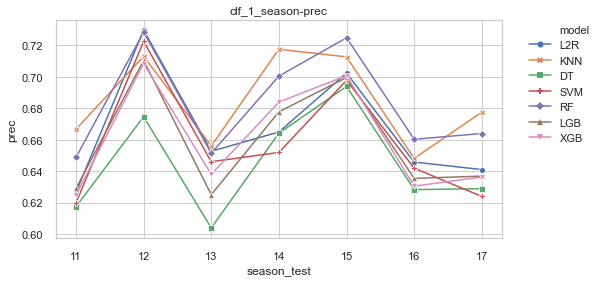

In [59]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [60]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0            10                1077           11                838
1            11                 838           12               1078
2            12                1078           13               1076
3            13                1076           14               1075
4            14                1075           15               1076
5            15                1076           16               1075
6            16                1075           17               1077

### Experiment using StandardScaler

In [61]:
experiment_name = f"{exp_prefix}scaled_data"

In [62]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_scaled_data
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
11  clf_scaled_data    RF   0.682070  0.032275      0.631216     0.023673
8   clf_scaled_data   KNN   0.675491  0.034029      0.616276     0.023942
13  clf_scaled_data   XGB   0.660286  0.033302      0.602817     0.028562
7   clf_scaled_data   L2R   0.658817  0.031629      0.598986     0.018980
12  clf_scaled_data   LGB   0.658190  0.032449      0.602887     0.027819
10  clf_scaled_data   SVM   0.653143  0.033928      0.591733     0.021153
9   clf_scaled_data    DT   0.643869  0.031111      0.574438     0.029023

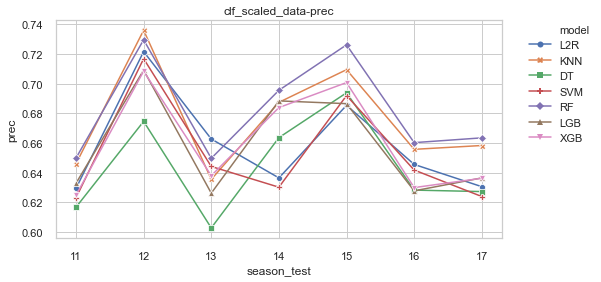

In [63]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))


In [64]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0            10                1077           11                838
1            11                 838           12               1078
2            12                1078           13               1076
3            13                1076           14               1075
4            14                1075           15               1076
5            15                1076           16               1075
6            16                1075           17               1077

### Experiment using MinMaxScaler

In [65]:
experiment_name = f"{exp_prefix}minmax_data"

In [66]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_minmax_data
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
18  clf_minmax_data    RF   0.681411  0.032222      0.630500     0.024092
15  clf_minmax_data   KNN   0.677922  0.029985      0.618850     0.021041
14  clf_minmax_data   L2R   0.665775  0.030697      0.612058     0.018699
17  clf_minmax_data   SVM   0.661336  0.030598      0.605329     0.017672
20  clf_minmax_data   XGB   0.660083  0.033313      0.602603     0.028543
19  clf_minmax_data   LGB   0.655596  0.032395      0.598340     0.027333
16  clf_minmax_data    DT   0.644404  0.030904      0.575131     0.028856

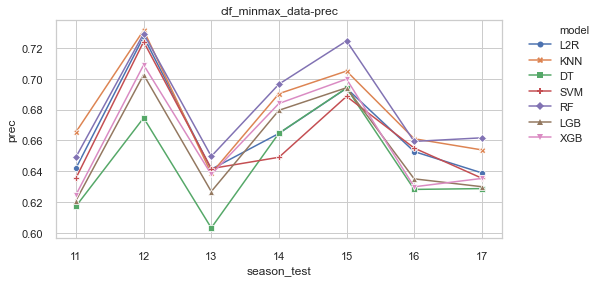

In [67]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [68]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0            10                1077           11                838
1            11                 838           12               1078
2            12                1078           13               1076
3            13                1076           14               1075
4            14                1075           15               1076
5            15                1076           16               1075
6            16                1075           17               1077

### Experiment: train: 2s; test: 1s

In [69]:
experiment_name = f"{exp_prefix}2_seasons"

In [70]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)



Running experiment clf_2_seasons
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
22  clf_2_seasons   KNN   0.684692  0.026786      0.626506     0.021991
21  clf_2_seasons   L2R   0.684436  0.039964      0.633346     0.030528
25  clf_2_seasons    RF   0.682227  0.022373      0.632720     0.018689
24  clf_2_seasons   SVM   0.680295  0.035101      0.627470     0.025292
26  clf_2_seasons   LGB   0.667996  0.024018      0.614668     0.024154
27  clf_2_seasons   XGB   0.666634  0.027256      0.610317     0.020756
23  clf_2_seasons    DT   0.635555  0.023180      0.559553     0.014746

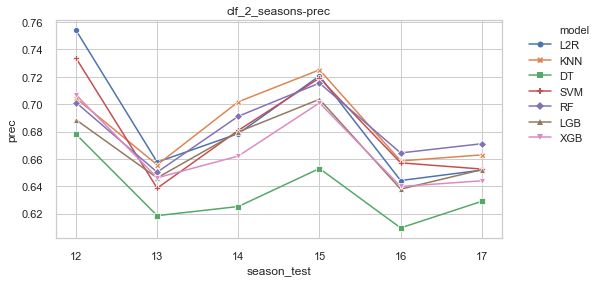

In [71]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [72]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0         10-11                1915           12               1078
1         11-12                1916           13               1076
2         12-13                2154           14               1075
3         13-14                2151           15               1076
4         14-15                2151           16               1075
5         15-16                2151           17               1077

### Experiment: train: 3s; test: 1s

In [73]:
experiment_name = f"{exp_prefix}3_seasons"

In [74]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3_seasons
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
32  clf_3_seasons    RF   0.678424  0.021258      0.634084     0.020115
29  clf_3_seasons   KNN   0.676875  0.022163      0.623985     0.022465
31  clf_3_seasons   SVM   0.676084  0.026471      0.632159     0.025478
28  clf_3_seasons   L2R   0.675976  0.026085      0.633495     0.026076
33  clf_3_seasons   LGB   0.669303  0.016110      0.623403     0.014920
34  clf_3_seasons   XGB   0.665649  0.017194      0.616520     0.018059
30  clf_3_seasons    DT   0.641888  0.033427      0.571177     0.032502

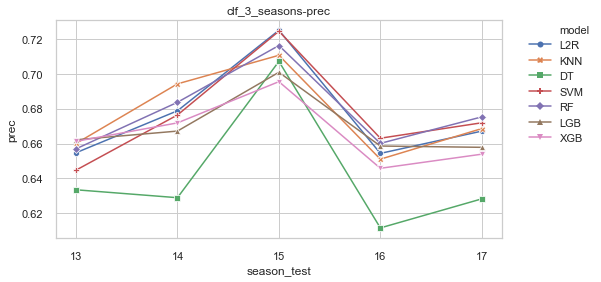

In [75]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [76]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0      10-11-12                2993           13               1076
1      11-12-13                2992           14               1075
2      12-13-14                3229           15               1076
3      13-14-15                3227           16               1075
4      14-15-16                3226           17               1077

### Experiment remove last 2q ; train: 2q ; test: 2q

In [77]:
experiment_name = f"{exp_prefix}2q_2q_r2q"

In [78]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.75, 1.0])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2q_2q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
36  clf_2q_2q   KNN   0.688932  0.049002      0.630647     0.030011
39  clf_2q_2q    RF   0.681975  0.044640      0.631118     0.028857
41  clf_2q_2q   XGB   0.664556  0.041473      0.603775     0.026083
35  clf_2q_2q   L2R   0.663848  0.037524      0.598861     0.025548
40  clf_2q_2q   LGB   0.659682  0.038179      0.600132     0.026441
38  clf_2q_2q   SVM   0.657938  0.032405      0.589716     0.023520
37  clf_2q_2q    DT   0.640991  0.032601      0.568457     0.023492

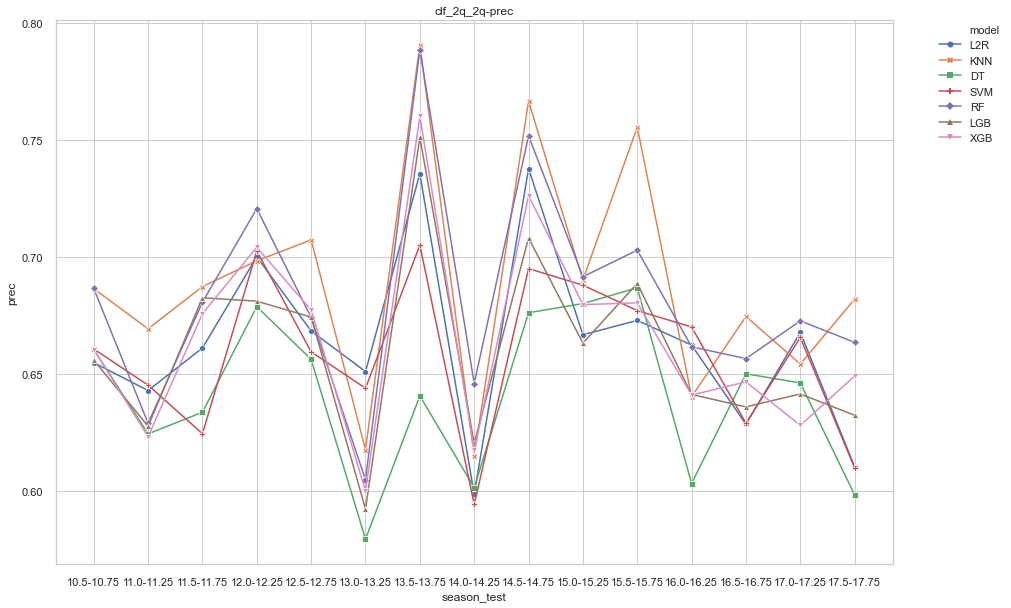

In [79]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [80]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0     10.0-10.25                 538   10.5-10.75                539
1     10.5-10.75                 539   11.0-11.25                419
2     11.0-11.25                 419   11.5-11.75                419
3     11.5-11.75                 419   12.0-12.25                539
4     12.0-12.25                 539   12.5-12.75                539
5     12.5-12.75                 539   13.0-13.25                538
6     13.0-13.25                 538   13.5-13.75                538
7     13.5-13.75                 538   14.0-14.25                537
8     14.0-14.25                 537   14.5-14.75                538
9     14.5-14.75                 538   15.0-15.25                538
10    15.0-15.25                 538   15.5-15.75                538
11    15.5-15.75                 538   16.0-16.25                537
12    16.0-16.25                 537   16.5-16.75                538
13    16.5-16.75                 538   17.0-17.25                538
14    17.0-17.25                 538   17.5-17.75                539

### Experiment remove first 2q ;train: 2q ; test: 2q

In [81]:
experiment_name = f"{exp_prefix}2q_2q_r2q"

In [82]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.25, 0.5])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2q_2q_r2q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
43  clf_2q_2q_r2q   KNN   0.708542  0.029431      0.644783     0.028211
46  clf_2q_2q_r2q    RF   0.706045  0.030783      0.650138     0.026285
48  clf_2q_2q_r2q   XGB   0.692893  0.022986      0.629086     0.018744
42  clf_2q_2q_r2q   L2R   0.686775  0.037995      0.615027     0.032376
45  clf_2q_2q_r2q   SVM   0.680159  0.028689      0.606057     0.028627
47  clf_2q_2q_r2q   LGB   0.677820  0.016268      0.614824     0.012588
44  clf_2q_2q_r2q    DT   0.655557  0.007718      0.570012     0.015696

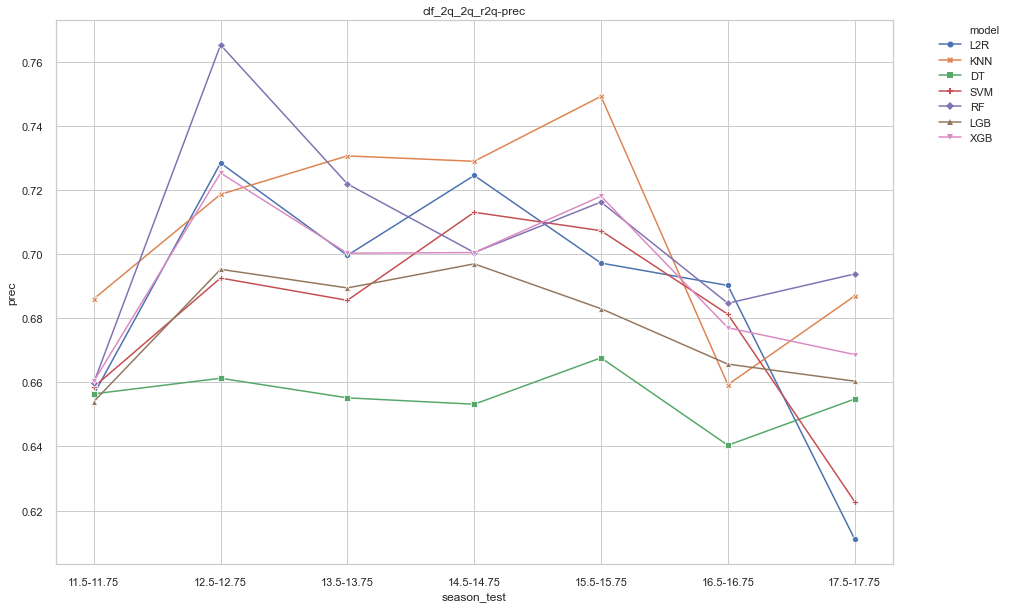

In [83]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [84]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0    10.5-10.75                 539   11.5-11.75                419
1    11.5-11.75                 419   12.5-12.75                539
2    12.5-12.75                 539   13.5-13.75                538
3    13.5-13.75                 538   14.5-14.75                538
4    14.5-14.75                 538   15.5-15.75                538
5    15.5-15.75                 538   16.5-16.75                538
6    16.5-16.75                 538   17.5-17.75                539

### Experiment train: remove last 1q ; 3q ; test: 1q ; step: 3q

In [85]:
experiment_name = f"{exp_prefix}3q_1q_r1q_s3q"

In [86]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, remove_quarters=[1.0], skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
50  clf_3q_1q   KNN   0.691969  0.049305      0.631470     0.035306
53  clf_3q_1q    RF   0.685966  0.043345      0.633715     0.033816
49  clf_3q_1q   L2R   0.675885  0.044965      0.617146     0.033995
52  clf_3q_1q   SVM   0.672692  0.044763      0.613004     0.030450
55  clf_3q_1q   XGB   0.670592  0.043870      0.611071     0.033231
54  clf_3q_1q   LGB   0.668991  0.041243      0.611286     0.038395
51  clf_3q_1q    DT   0.634010  0.050327      0.558329     0.039290

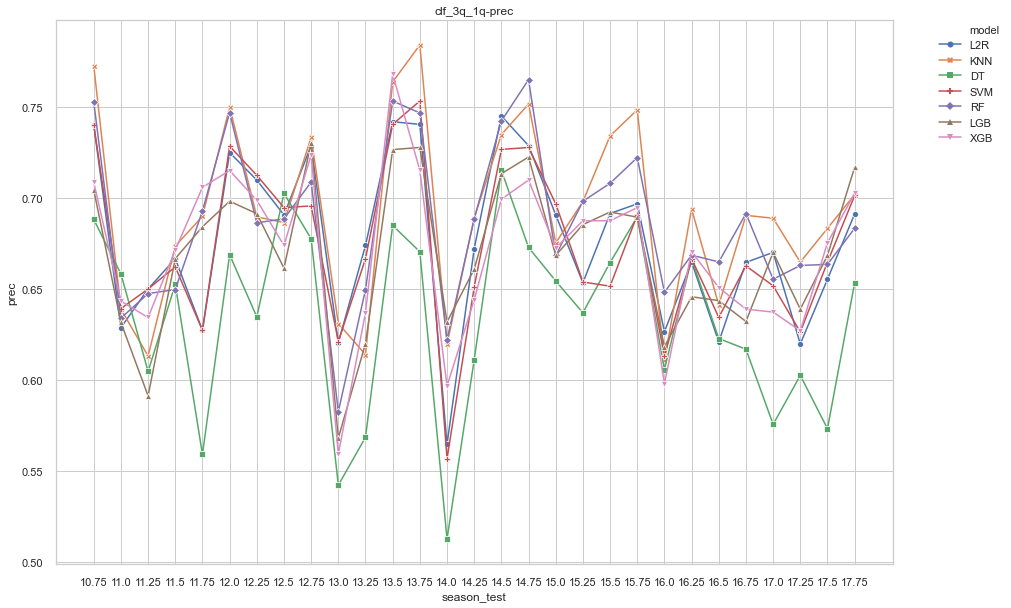

In [87]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [88]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0    10.0-10.25-10.5                 807        10.75                270
1   10.25-10.5-10.75                 808         11.0                209
2    10.5-10.75-11.0                 748        11.25                210
3   10.75-11.0-11.25                 689         11.5                209
4    11.0-11.25-11.5                 628        11.75                210
5   11.25-11.5-11.75                 629         12.0                269
6    11.5-11.75-12.0                 688        12.25                270
7   11.75-12.0-12.25                 749         12.5                269
8    12.0-12.25-12.5                 808        12.75                270
9   12.25-12.5-12.75                 809         13.0                269
10   12.5-12.75-13.0                 808        13.25                269
11  12.75-13.0-13.25                 808         13.5                269
12   13.0-13.25-13.5                 807        13.75                269
13  13.25-13.5-13.75                 807         14.0                268
14   13.5-13.75-14.0                 806        14.25                269
15  13.75-14.0-14.25                 806         14.5                269
16   14.0-14.25-14.5                 806        14.75                269
17  14.25-14.5-14.75                 807         15.0                269
18   14.5-14.75-15.0                 807        15.25                269
19  14.75-15.0-15.25                 807         15.5                269
20   15.0-15.25-15.5                 807        15.75                269
21  15.25-15.5-15.75                 807         16.0                268
22   15.5-15.75-16.0                 806        16.25                269
23  15.75-16.0-16.25                 806         16.5                269
24   16.0-16.25-16.5                 806        16.75                269
25  16.25-16.5-16.75                 807         17.0                269
26   16.5-16.75-17.0                 807        17.25                269
27  16.75-17.0-17.25                 807         17.5                269
28   17.0-17.25-17.5                 807        17.75                270

### Experiment train: 3q ; test: 1q ; step: 3q

In [89]:
experiment_name = f"{exp_prefix}3q_1q_3s"

In [90]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q_3s
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
57  clf_3q_1q_3s   KNN   0.734080  0.034295      0.658122     0.026132
60  clf_3q_1q_3s    RF   0.720423  0.029262      0.657153     0.025716
56  clf_3q_1q_3s   L2R   0.702298  0.037924      0.625891     0.039325
61  clf_3q_1q_3s   LGB   0.701003  0.030558      0.629848     0.045091
62  clf_3q_1q_3s   XGB   0.699929  0.024417      0.624007     0.037747
59  clf_3q_1q_3s   SVM   0.699891  0.038766      0.621828     0.039517
58  clf_3q_1q_3s    DT   0.653516  0.041858      0.564450     0.042167

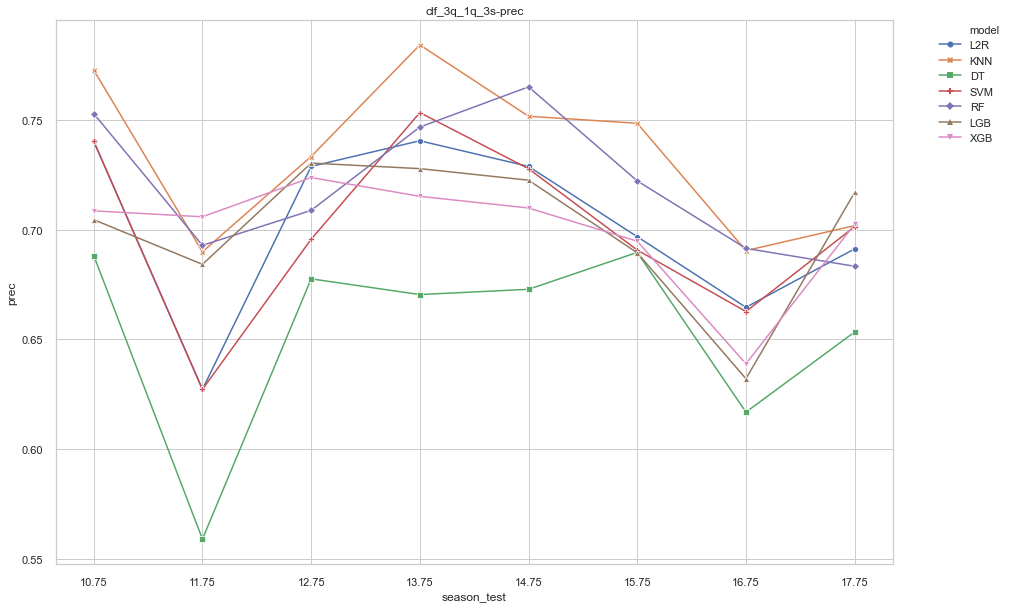

In [91]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [92]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0  10.0-10.25-10.5                 807        10.75                270
1  11.0-11.25-11.5                 628        11.75                210
2  12.0-12.25-12.5                 808        12.75                270
3  13.0-13.25-13.5                 807        13.75                269
4  14.0-14.25-14.5                 806        14.75                269
5  15.0-15.25-15.5                 807        15.75                269
6  16.0-16.25-16.5                 806        16.75                269
7  17.0-17.25-17.5                 807        17.75                270

### Experiment train: 4q ; test: 2q

In [93]:
experiment_name = f"{exp_prefix}4q_2q"

In [94]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
64  clf_4q_2q   KNN   0.686201  0.043208      0.627250     0.028433
67  clf_4q_2q    RF   0.683647  0.042209      0.634530     0.032507
63  clf_4q_2q   L2R   0.676506  0.049223      0.621944     0.033511
69  clf_4q_2q   XGB   0.668465  0.050708      0.610774     0.040423
68  clf_4q_2q   LGB   0.667608  0.048986      0.611861     0.032738
66  clf_4q_2q   SVM   0.667554  0.045816      0.609311     0.028319
65  clf_4q_2q    DT   0.642207  0.040236      0.568837     0.028774

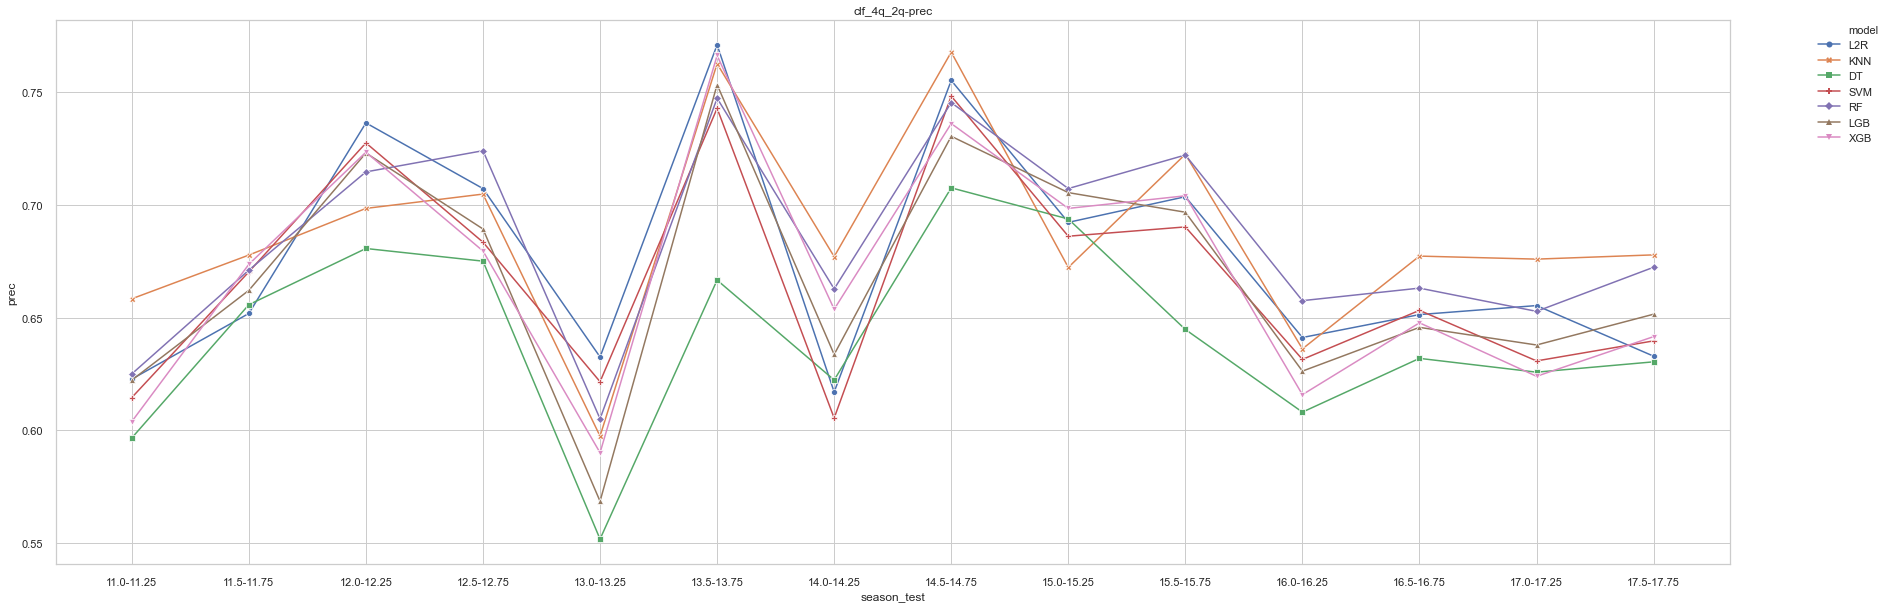

In [95]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(30,10))

In [96]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0   10.0-10.25-10.5-10.75                1077   11.0-11.25                419
1   10.5-10.75-11.0-11.25                 958   11.5-11.75                419
2   11.0-11.25-11.5-11.75                 838   12.0-12.25                539
3   11.5-11.75-12.0-12.25                 958   12.5-12.75                539
4   12.0-12.25-12.5-12.75                1078   13.0-13.25                538
5   12.5-12.75-13.0-13.25                1077   13.5-13.75                538
6   13.0-13.25-13.5-13.75                1076   14.0-14.25                537
7   13.5-13.75-14.0-14.25                1075   14.5-14.75                538
8   14.0-14.25-14.5-14.75                1075   15.0-15.25                538
9   14.5-14.75-15.0-15.25                1076   15.5-15.75                538
10  15.0-15.25-15.5-15.75                1076   16.0-16.25                537
11  15.5-15.75-16.0-16.25                1075   16.5-16.75                538
12  16.0-16.25-16.5-16.75                1075   17.0-17.25                538
13  16.5-16.75-17.0-17.25                1076   17.5-17.75                539

### Experiment remove first 2q ; train: 4q ; test: 2q

In [97]:
experiment_name = f"{exp_prefix}4q_2q_r2q"

In [98]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2, remove_quarters=[0.25, 0.50])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q_r2q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
71  clf_4q_2q_r2q   KNN   0.712712  0.025745      0.646037     0.027462
74  clf_4q_2q_r2q    RF   0.709438  0.014701      0.653729     0.021303
70  clf_4q_2q_r2q   L2R   0.706215  0.034781      0.638579     0.027117
73  clf_4q_2q_r2q   SVM   0.702433  0.034585      0.635187     0.027401
76  clf_4q_2q_r2q   XGB   0.700360  0.029903      0.638773     0.027068
75  clf_4q_2q_r2q   LGB   0.692100  0.018309      0.632635     0.013823
72  clf_4q_2q_r2q    DT   0.661376  0.021299      0.580310     0.019090

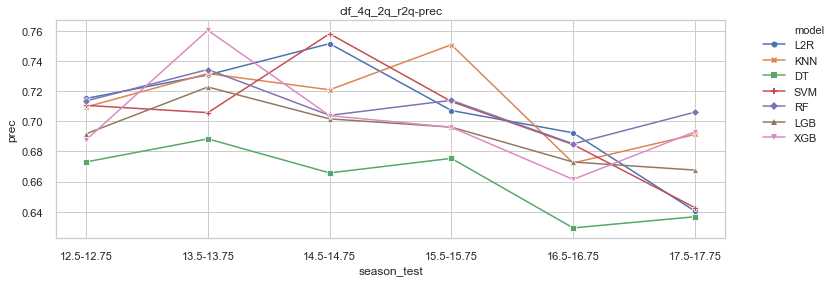

In [99]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [100]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0  10.5-10.75-11.5-11.75                 958   12.5-12.75                539
1  11.5-11.75-12.5-12.75                 958   13.5-13.75                538
2  12.5-12.75-13.5-13.75                1077   14.5-14.75                538
3  13.5-13.75-14.5-14.75                1076   15.5-15.75                538
4  14.5-14.75-15.5-15.75                1076   16.5-16.75                538
5  15.5-15.75-16.5-16.75                1076   17.5-17.75                539

### Experiments comparison

In [101]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [102]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [103]:
ba_df = exp_df[['exp_name', 'model',
       'prec_mean', 'prec_std', 'bal_acc_mean', 'bal_acc_std']]

In [104]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [ ]:
ba_df.sort_values(
    by=["prec_mean"]
    , ascending=False)[:10].reset_index().drop(labels=["index"], axis=1)

ba_df.sort_values(
    by=["prec_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

In [106]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

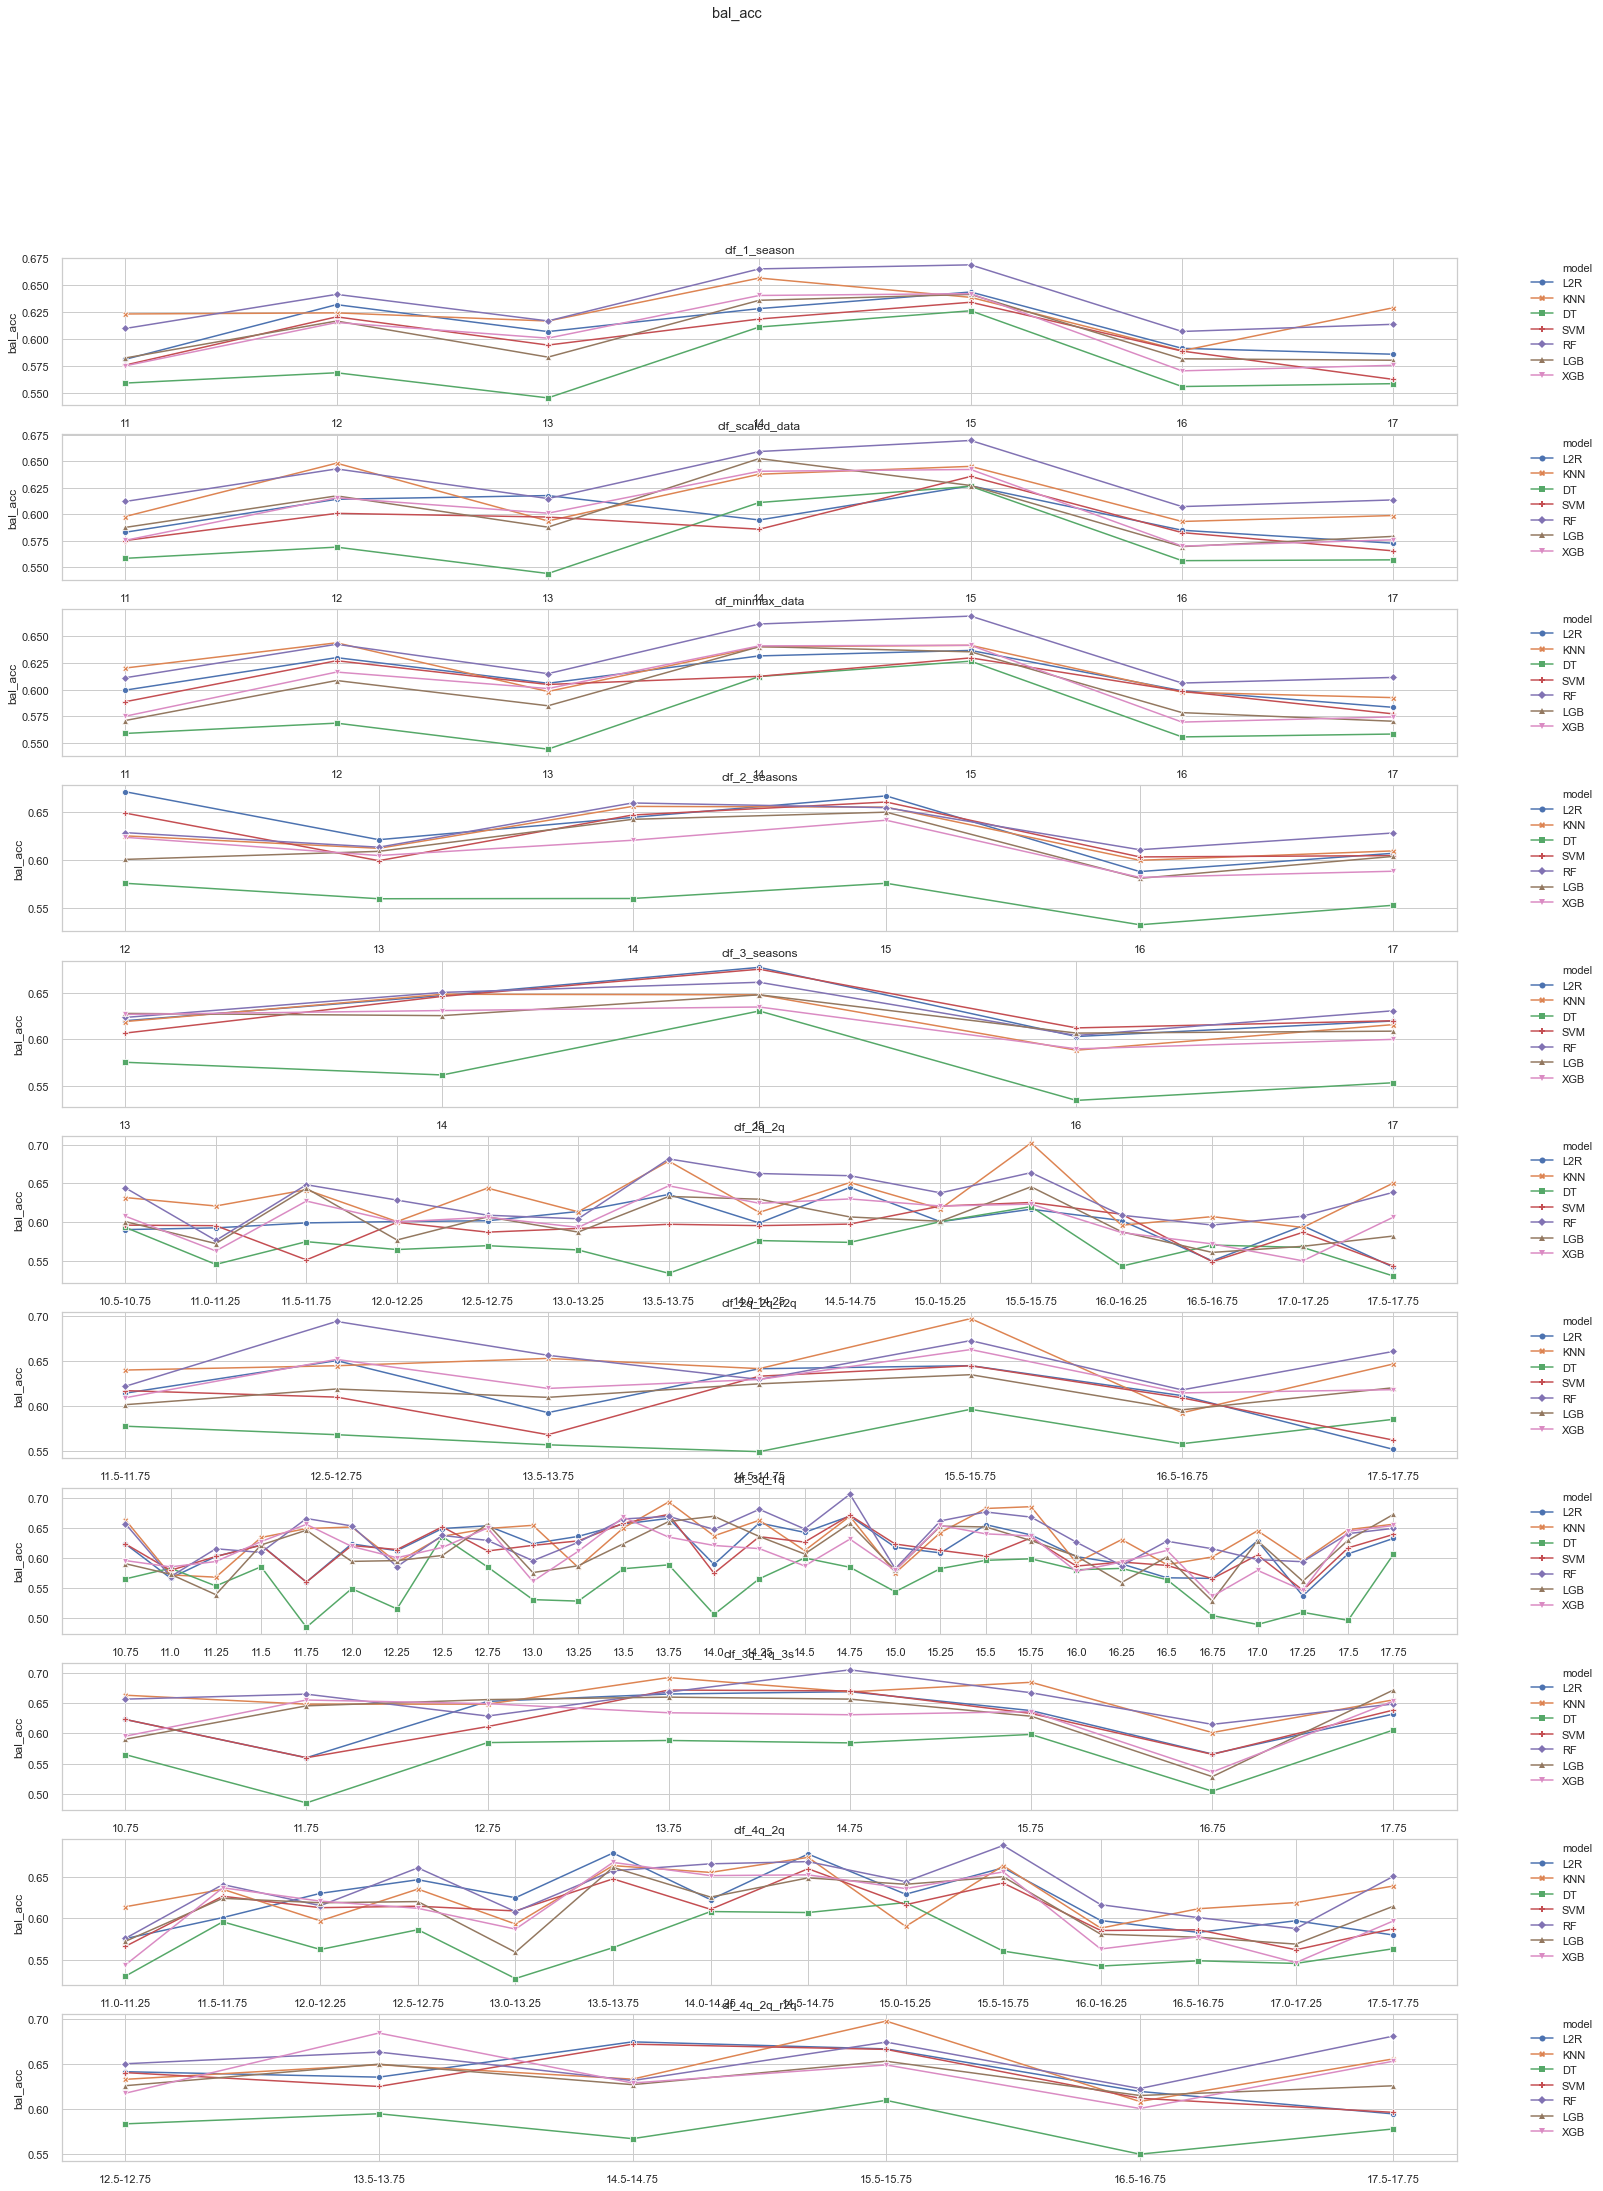

In [107]:
utils.plot_to_compare_experiments(
    results_total,
    metric="bal_acc",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

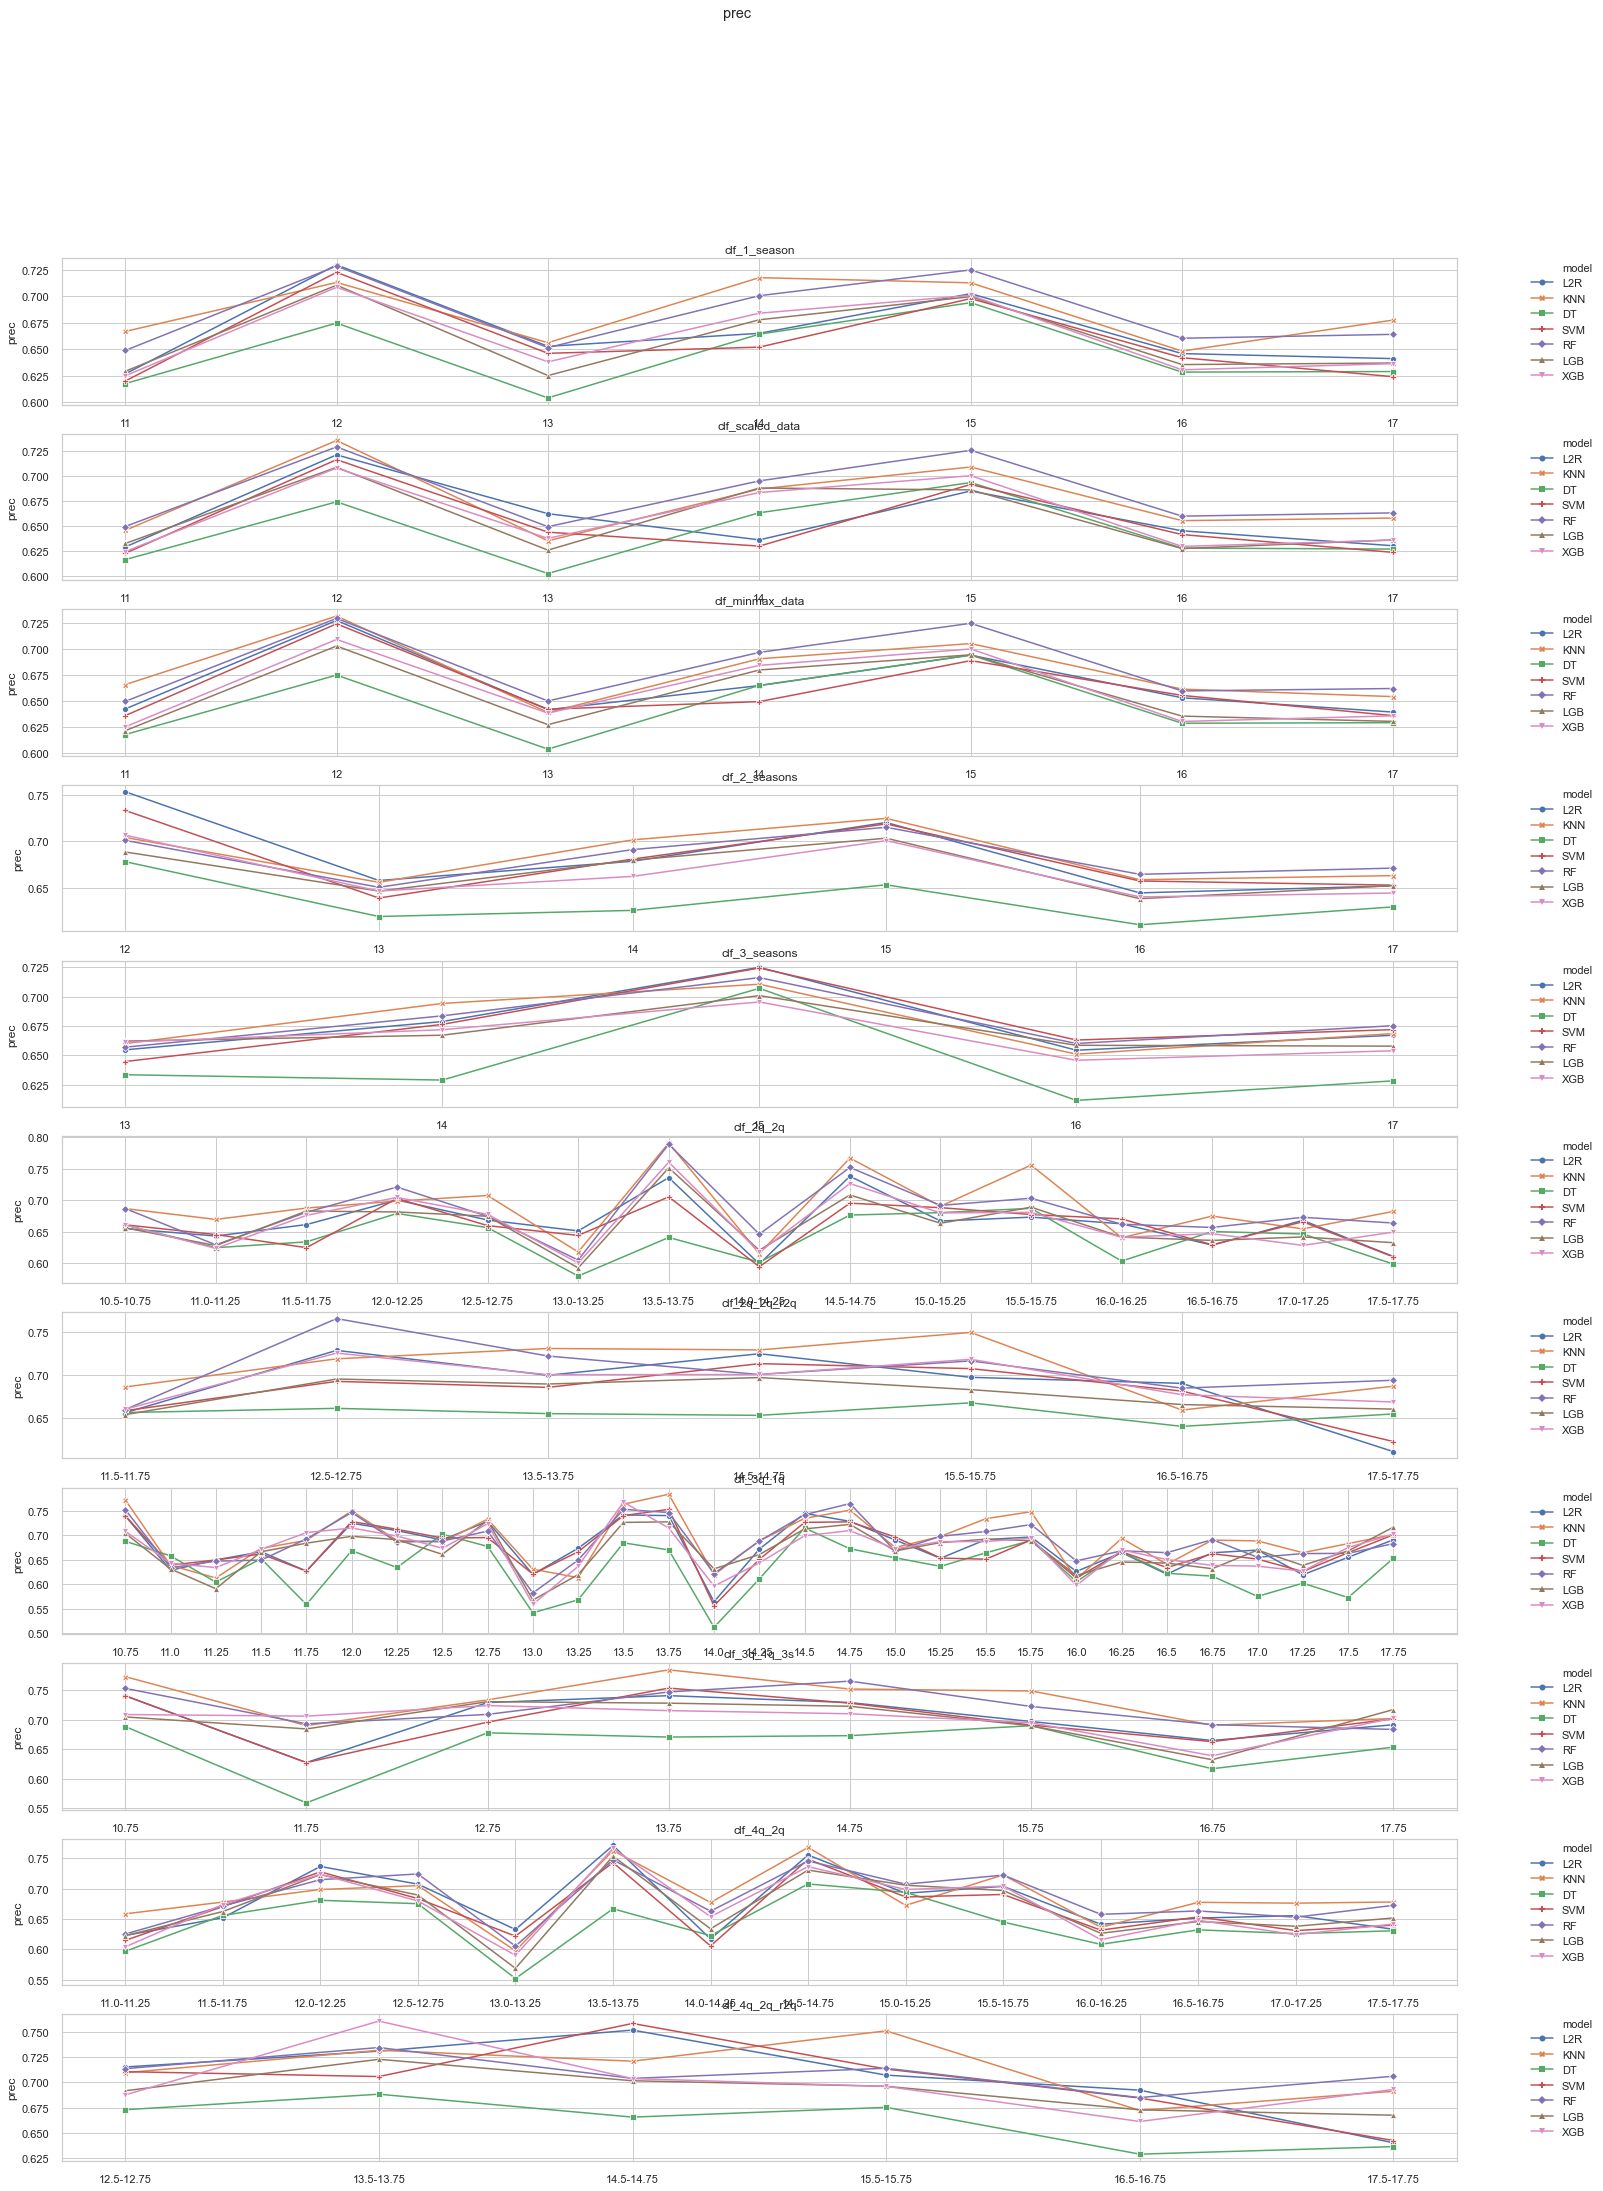

In [108]:
utils.plot_to_compare_experiments(
    results_total,
    metric="prec",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

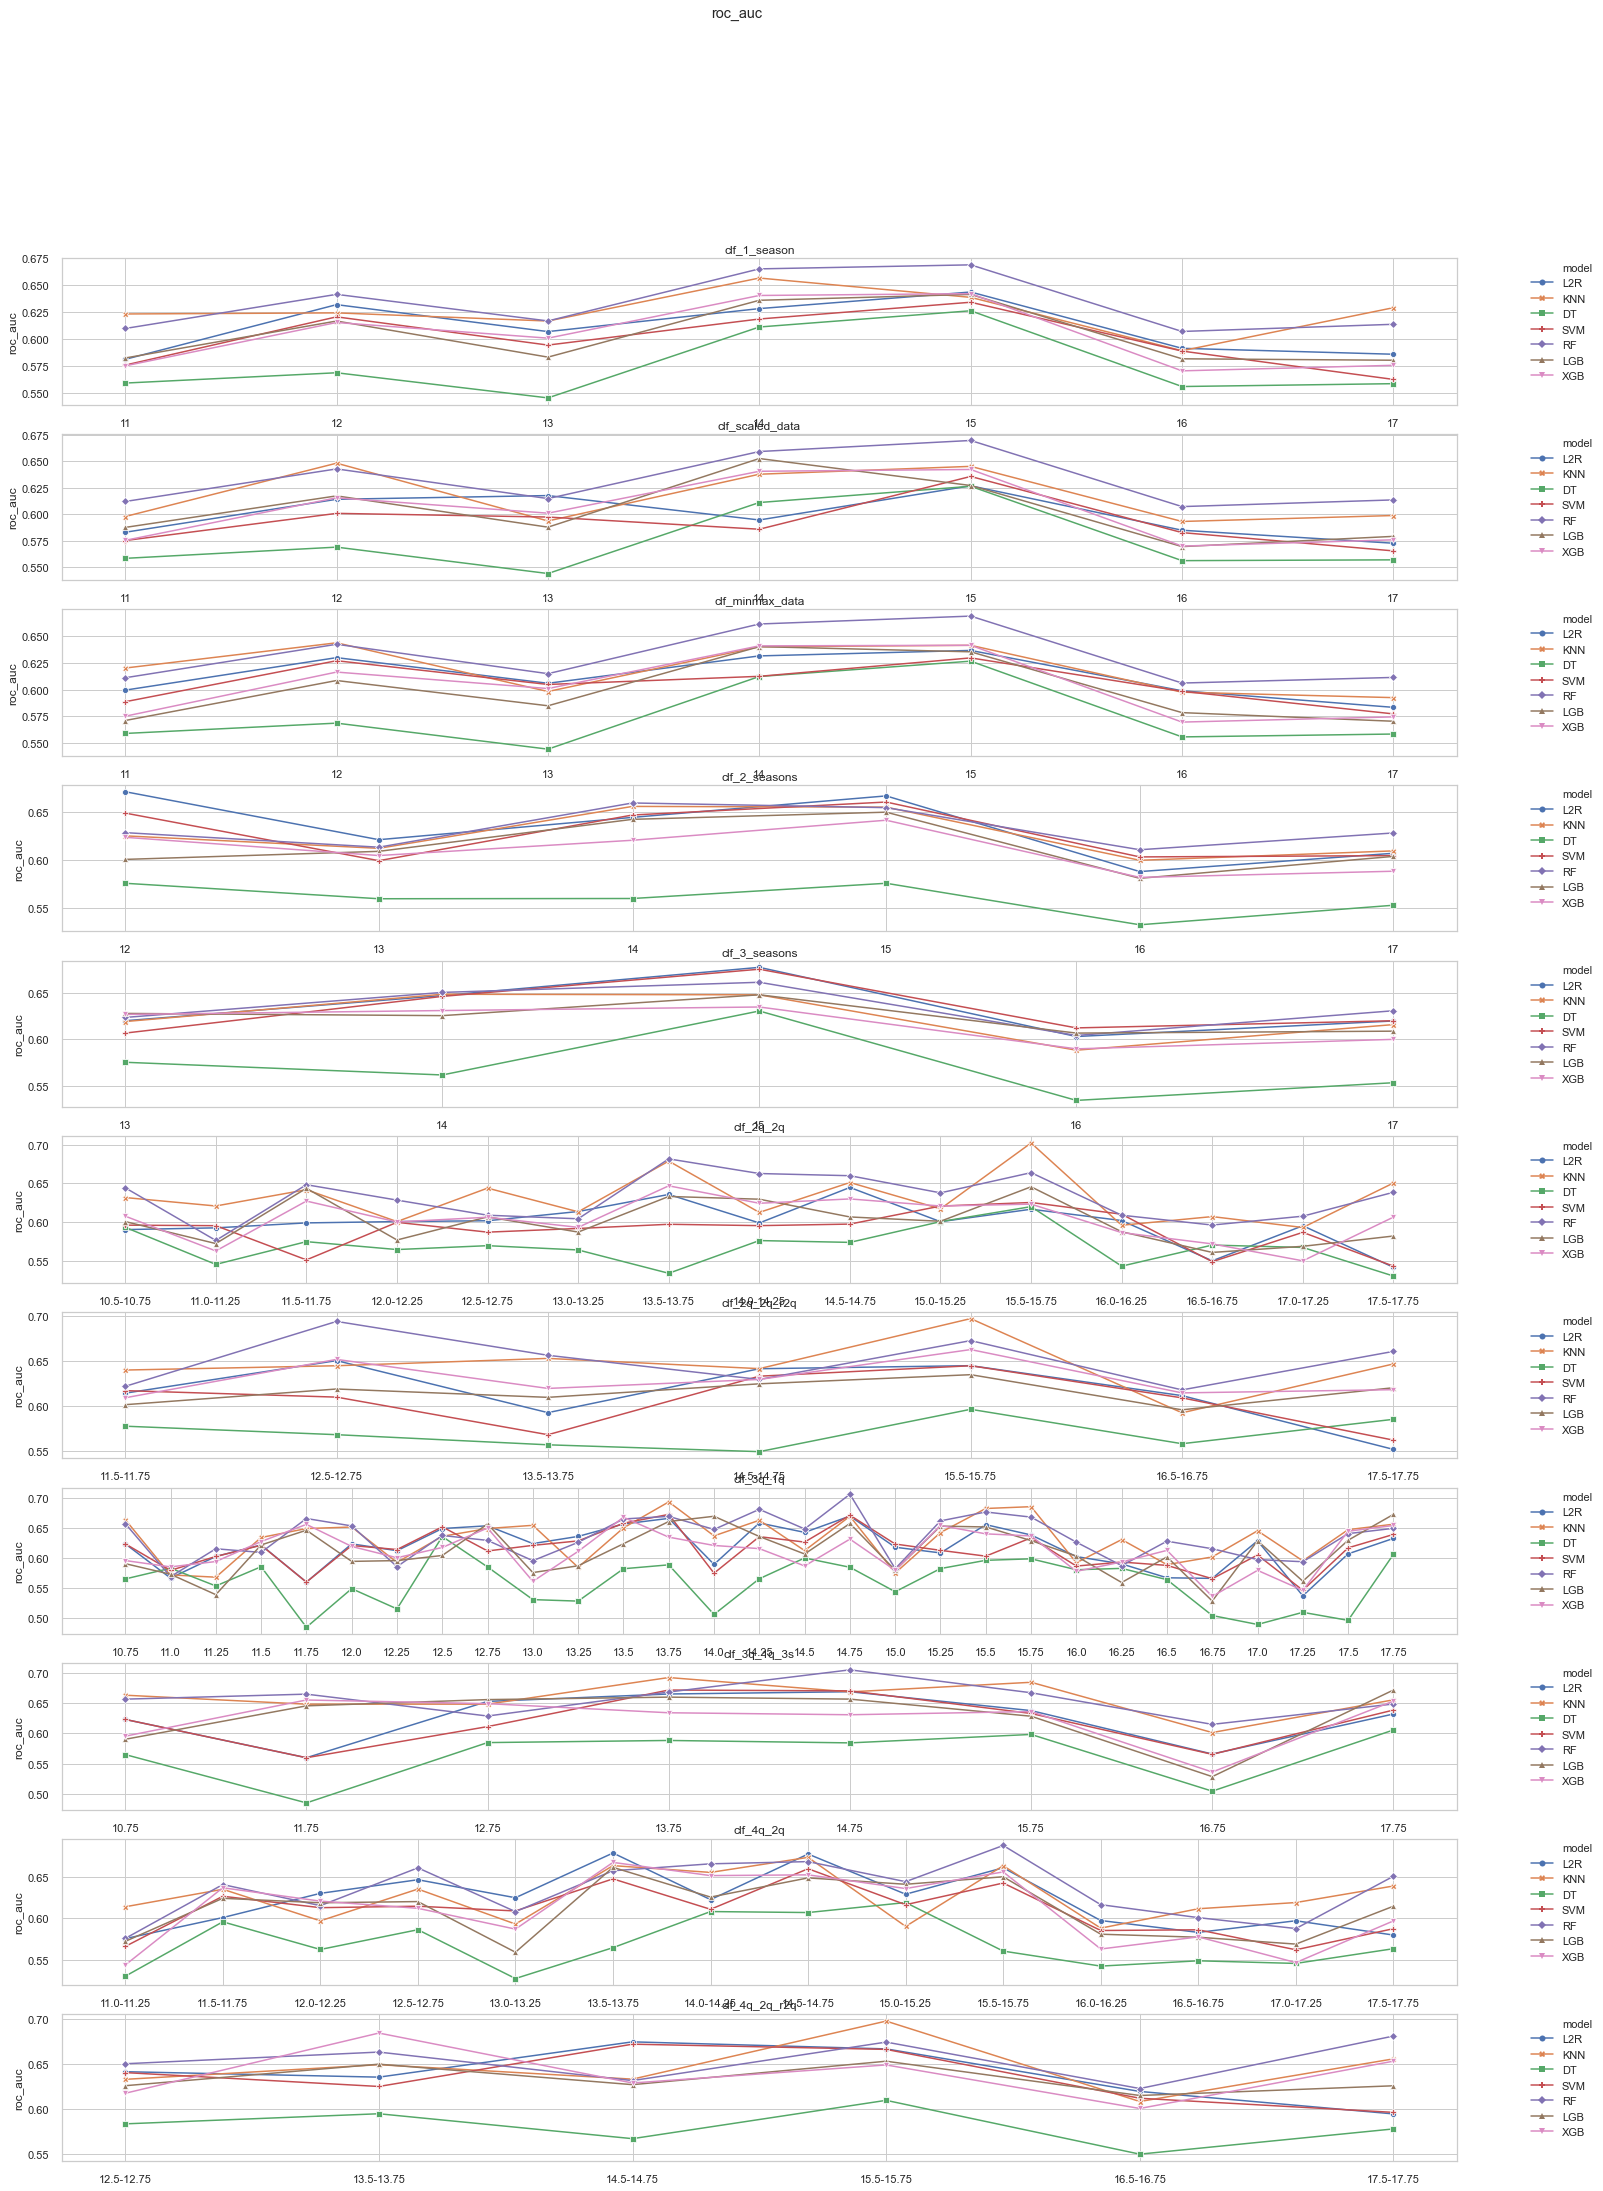

In [109]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)